In [778]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [779]:
def find_files(folder):
    tmp = os.listdir(folder)
    files = []
    for f in tmp:
        if 'cond' in f:
            files.append(f)
    return(files)

In [780]:
def get_scr(data):
    
    data.columns = ['ch1', 'ch2','ch3','ch4', 'ch5']
    data.drop(columns=['ch2', 'ch4', 'ch5'])
    
    # get events into boolean 
    data.ch3 = data.ch3 > 0 # beginning of an event, this is what will be used 
    
    # fix spikes
    for column in data.columns[1:]:
        n = pd.Series([0]).append(data[column], ignore_index=True)
        n.drop(n.tail(1).index,inplace=True)
        data[column] = (data[column] - n) > 0 
    
    # find spikes 
    CH3idx = data[data.ch3==1].index

    # calculate & extract SCR
    SCR=[]
    for i in CH3idx:
        BASEidx = i-400 # this is 2s * 200Hz sampling rate
        EVENTidx = i+1200 # this is 6s * 200Hz sampling rate

        BASE = np.mean(data.loc[BASEidx:i, 'ch1'])
        EVENT = np.max(data.loc[i:EVENTidx, 'ch1'])
        SCR.append(EVENT - BASE)

    # return only the last 16 events if there were more
    return(np.array(SCR[-16:]))

In [781]:
def add_row(df, name, SCR):
    # define CS+ and CS- events 
    CSplus = np.array([1,1,0,1,0,1,0,0,1,0,0,1,1,0,1,0], dtype=bool)
    CSminus = np.logical_not(CSplus)
    
    # add a new row
    new_row = [name] + list(SCR[CSplus])+ list(SCR[CSminus])
    df.loc[df.shape[0]] = new_row
    return(df)

In [782]:
def add_aggregate(df):
    agg = ['CSplus_mean','CSplus_mean_sqrt', 'CSminus_mean','CSminus_mean_sqrt']
    drop = [ i for i in agg if i in df.columns ]
    df=df.drop(columns=drop) 
    
    df['CSplus_mean'] = df[['CSplus' + str(i) for i in range(1,9)]].mean(axis=1)
    df['CSplus_mean_sqrt'] = np.sqrt(abs(df['CSplus_mean'])) * np.sign(df['CSplus_mean'])

    df['CSminus_mean'] = df[['CSminus' + str(i) for i in range(1,9)]].mean(axis=1)
    df['CSminus_mean_sqrt'] = np.sqrt(abs(df['CSminus_mean'])) * np.sign(df['CSminus_mean'])

    return(df)


In [783]:
# SCR dataframe 
df = pd.DataFrame(columns=['name'] + 
                  ['CSplus' + str(i)for i in range(1,9)] + 
                  ['CSminus' + str(i)for i in range(1,9)]) 

folders = ['/Users/laurituominen/Dropbox/SCR_MGH_FG1/SCR_data/Filtered_HC_ALL_after_visualQC/', 
           '/Users/laurituominen/Dropbox/SCR_MGH_FG1/SCR_data/Filtered_SCH_after_visualQC/']

for folder in folders: 
    files = find_files(folder)
    for name in files:
        data = pd.read_csv(folder + name, sep='\t', header=None)
        SCR = get_scr(data)
        add_row(df, name, SCR)


df = add_aggregate(df)

df['Group'] = ['CTR'] * 33 + ['SCZ'] *23
        
df.to_csv('/Users/laurituominen/Dropbox/SCR_MGH_FG1/EventByEvent_SCR.csv')

## plot mean values

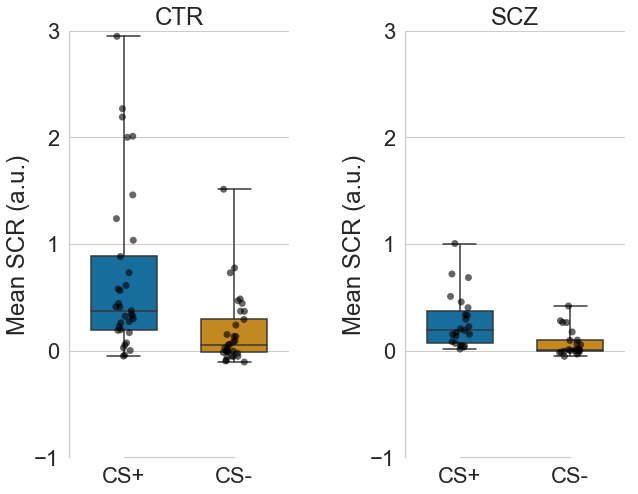

In [784]:
# create data set 
d1= df[['CSplus_mean', 'CSplus_mean_sqrt', 'Group']]
d2 = df[['CSminus_mean', 'CSminus_mean_sqrt', 'Group']]
d1.columns = d2.columns = ['SCR', 'SCR_sqrt', 'Group']
df_plot = pd.concat([d1,d2])
df_plot['xaxis'] = ['CS+'] * d1.shape[0] + ['CS-'] * d2.shape[0]

# plot data
sns.set(style="whitegrid", palette="muted", color_codes=True,font_scale = 2)
f, ax = plt.subplots(1,2, figsize=(10, 8))
# Plot the orbital period with horizontal boxes
sns.boxplot(ax=ax[0], x="xaxis", y="SCR", data=df_plot[df_plot['Group'] == 'CTR'],
            whis=[0, 100], width=.6, palette="colorblind")
sns.stripplot(ax=ax[0], x="xaxis", y="SCR", data=df_plot[df_plot['Group'] == 'CTR'],
              size=7, alpha=0.6,color='black', linewidth=0)
ax[0].set(xlabel="",ylabel='Mean SCR (a.u.)',ylim = (-1,3), yticks=[-1, 0, 1, 2, 3], title ='CTR')
sns.despine(ax=ax[0], trim=True)


sns.boxplot(ax=ax[1], x="xaxis", y="SCR", data=df_plot[df_plot['Group'] == 'SCZ'],
            whis=[0, 100], width=.6, palette="colorblind")
sns.stripplot(ax=ax[1], x="xaxis", y="SCR", data=df_plot[df_plot['Group'] == 'SCZ'],
              size=7,alpha=0.6, color='black', linewidth=0)
ax[1].set(xlabel="",ylabel='Mean SCR (a.u.)',ylim = (-1,3), yticks=[-1, 0, 1, 2, 3], title ='SCZ')
sns.despine(ax=ax[1], trim=True)
plt.tight_layout(pad=2)

f.savefig('/Users/laurituominen/Dropbox/SCR_MGH_FG1/figures/GroupDifferences.png')


# Plot time series

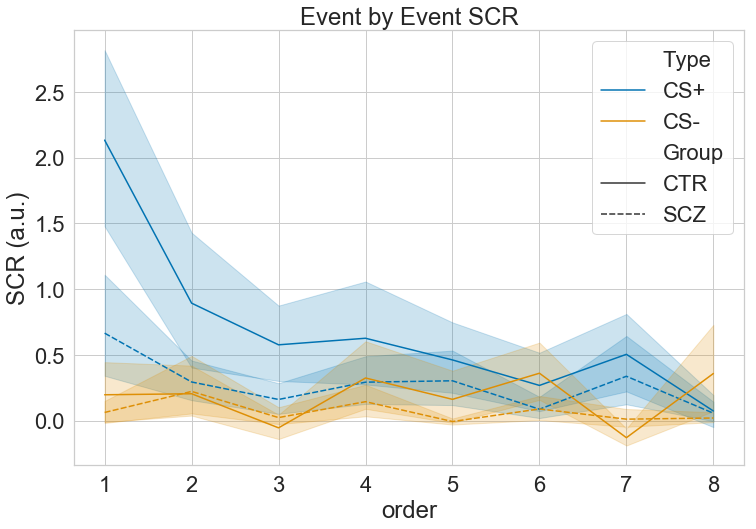

In [785]:
sns.set(style="whitegrid", palette="muted", color_codes=True,font_scale = 2)
f, ax = plt.subplots(1, figsize=(12, 8))

d2= pd.melt(df, id_vars=['name', 'Group'], value_vars=df.columns[1:17])
d2['Type'] = ['CS+' if 'CSplus' in i else 'CS-' for i in d2.variable ]
d2['order'] =d2['variable'].str[-1]

sns.lineplot(data=d2, x="order", y="value", hue='Type', style='Group',palette="colorblind");
ax.set(ylabel='SCR (a.u.)', title ='Event by Event SCR')

f.savefig('/Users/laurituominen/Dropbox/SCR_MGH_FG1/figures/EventByEvent.png')
